# Ensemble Learners

## Setup

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "MINST"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = True
SEED = 12

In [33]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

### Imports

In [34]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

## Datasets

In [35]:
# %conda update -n base -c defaults conda

In [36]:
# %conda install -y openml

In [37]:
from openml.datasets import list_datasets, get_dataset
df_openml = list_datasets(output_format="dataframe")

## okcupid

### Load dataset

In [38]:
did = 41440

name = df_openml.loc[(df_openml.did==did), "name"].values[0]

print(f"Fetching database name:{name} id:{did}")

dataset = get_dataset(did)

Fetching database name:okcupid-stem id:41440


In [39]:
print(f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
display(Markdown(dataset.description))

This is dataset 'okcupid-stem', the target feature is 'job'
URL: https://api.openml.org/data/v1/download/20829061/okcupid-stem.arff


User profile data for San Francisco OkCupid users published in [Kim, A. Y., & Escobedo-Land, A. (2015). OKCupid data for introductory statistics and data science courses. Journal of Statistics Education, 23(2).]. The curated dataset was downloaded from [https://github.com/rudeboybert/JSE_OkCupid]. The original dataset was created with the use of a python script that pulled the data from public profiles on www.okcupid.com on 06/30/2012. It includes people (n = 59946) within a 25 mile radius of San Francisco, who were online in the last year (06/30/2011), with at least one profile picture. Permission to use this data was obtained by the author of the original paper from OkCupid president and co-founder Christian Rudder under the condition that the dataset remains public. As target, the variable 'job' was collapsed into three categories: 'stem', 'non_stem', and 'student'. STEM jobs were defined as 'job' %in% c('computer / hardware / software', 'science / tech / engineering'). Observations with 'job' %in% c('unemployed', 'retired', 'rather not say') or missing values in 'job' were removed. The original dataset also included ten open text variables 'essay0' to 'essay9', which were removed from the dataset uploaded here. The dataset further includes the date/time variable 'last_online' (ignored by default) which could be used to construct additional features. Using OkCupid data for predicting STEM jobs was inspired by Max Kuhns book 'Feature Engineering and Selection: A Practical Approach for Predictive Models' [https://bookdown.org/max/FES/].

In [40]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

In [41]:
target = dataset.default_target_attribute
df = pd.DataFrame(data=X, columns=attribute_names)
df[target] = y
print(df.shape)
df.head()

(50789, 20)


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,job
0,22.0,0.0,10.0,4.0,0.0,24.0,95.0,75.0,NaN,160.0,2.0,2.0,14.0,3.0,1.0,16.0,1.0,1.0,3.0,1
1,35.0,2.0,6.0,2.0,2.0,30.0,206.0,70.0,6.0,107.0,2.0,2.0,14.0,4.0,1.0,8.0,0.0,4290.0,3.0,1
2,23.0,10.0,17.0,4.0,NaN,24.0,206.0,71.0,0.0,14.0,4.0,2.0,10.0,NaN,1.0,28.0,0.0,5978.0,3.0,2
3,29.0,1.0,NaN,4.0,0.0,9.0,21.0,66.0,NaN,141.0,NaN,2.0,14.0,NaN,1.0,0.0,0.0,1.0,3.0,1
4,29.0,2.0,3.0,4.0,NaN,9.0,206.0,67.0,NaN,141.0,2.0,2.0,10.0,5.0,1.0,40.0,0.0,560.0,3.0,0


### Preprocessing

In [42]:
print(df.shape)
df.fillna(0, inplace=True)
print(df.shape)
X, y = df[attribute_names].values, df[target].values

(50789, 20)
(50789, 20)


* Train models using train dataset
* After training we score with validation dataset while setting hyperparameters.
* Then use test to evaluate the model.

In [43]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=SEED)

X_train.shape, X_val.shape, X_test.shape

((30473, 19), (10158, 19), (10158, 19))

In [44]:
if name=='mnist_784':
    plt.imshow(X_train[0].reshape(28,28), cmap='Greys')
    plt.show()
else:
    display(X_train[0])

array([ 31.,   2.,   8.,   4.,   0.,   9., 197.,  64.,   0., 141.,   0.,
         2.,  11.,  27.,   0.,  26.,   0., 114.,   3.], dtype=float32)

In [45]:
y_train[0]

1

### AdaBoost

In [46]:
base_estimator = DecisionTreeClassifier(max_depth=1)

ada_clf = AdaBoostClassifier(
    base_estimator=base_estimator, 
    n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=SEED)

ada_clf.fit(X_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=12)

In [47]:
ada_clf.score(X_train, y_train)

0.7408525580021659

In [48]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.7415829887773183

## WHAT DOES THESE VALUES MEAN?

They are very similar indicating the model is not overfitting, and the model is doing as well as it can. (Scores on train data is fairly similar to the scores on test data)



In [49]:
# create a list of all possible depth values
depths = [1,2,3,4,5,6]

models = []
train_accuracy = []
val_accuracy = []

# create a list of models 
for depth in depths:
    base_estimator = DecisionTreeClassifier(max_depth=depth)
    model = AdaBoostClassifier(
        estimator=base_estimator, 
        n_estimators=20, algorithm="SAMME.R", learning_rate=0.5, random_state=SEED)
    model.fit(X_train, y_train)
    models.append(model)

    # evaluate model performance
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    train_accuracy.append(train_score)
    val_accuracy.append(val_score)
    print('Depth: {} Train Accuracy: {} Val Accuracy: {}'.format(depth, train_score, val_score))

Depth: 1 Train Accuracy: 0.7279887113182161 Val Accuracy: 0.7263240795432172
Depth: 2 Train Accuracy: 0.7362911429790306 Val Accuracy: 0.7368576491435322
Depth: 3 Train Accuracy: 0.7408853739375841 Val Accuracy: 0.7342980901752314
Depth: 4 Train Accuracy: 0.7505660748859646 Val Accuracy: 0.7419767670801339
Depth: 5 Train Accuracy: 0.7495815968234174 Val Accuracy: 0.7370545382949399
Depth: 6 Train Accuracy: 0.7697633971056345 Val Accuracy: 0.7309509746012994


## WHAT DOES THESE VALUES MEAN?

Train score keeps getting better
Validation score is getting better then losing accuracy. This is a sign of overfitting. We should stop training at this point.

Other values to tweak is n_estimators and learning_rate

The following graph shows the accuracy over the depths

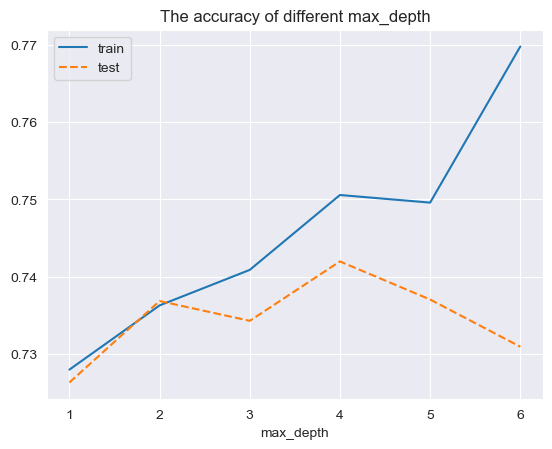

In [50]:
plt.plot(depths, train_accuracy, '-', label='train')
plt.plot(depths, val_accuracy, '--', label='test')
plt.title('The accuracy of different max_depth')
plt.xlabel("max_depth")
plt.xticks(depths)
plt.legend()
plt.show()

In [51]:
best_model = models[np.argmax(val_accuracy)]
best_model.score(X_test, y_test)

0.7447332151998425

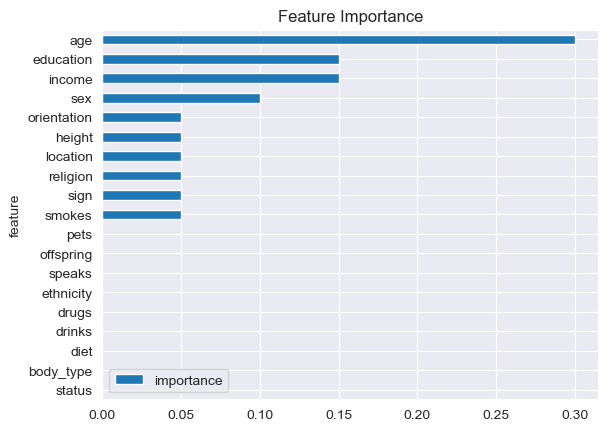

In [52]:
df_tmp = pd.DataFrame({'feature':attribute_names, 'importance':models[0].feature_importances_})

df_tmp.sort_values('importance').plot(kind='barh', x='feature')
plt.title("Feature Importance")
plt.show()

## Gradient Boosting Classifier

In [53]:
gbrt = GradientBoostingClassifier(max_depth=2, subsample = 0.5, tol = 0.01, n_estimators=50, random_state=SEED)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=12,
                           subsample=0.5, tol=0.01)

In [54]:
errors = [log_loss(y_val, y_pred)
          for y_pred in gbrt.staged_predict_proba(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingClassifier(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=42)

In [55]:
min_error = np.min(errors)
min_error

0.6010807000151055

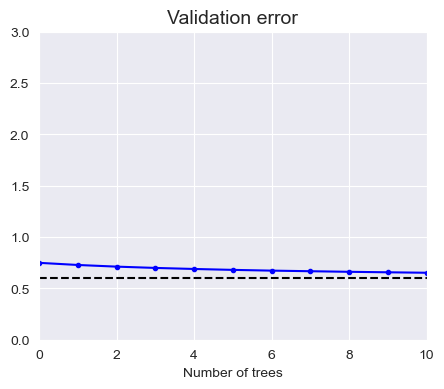

In [56]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 10], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.axis([0, 10, 0, 3])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)
plt.show()

## XGBoost


In [57]:
import xgboost

In [58]:
# filter the original data set
criteria = (df[target]==0) | (df[target]==1)
X, y = df.loc[criteria, attribute_names].values, df.loc[criteria,target].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=SEED)

X_train.shape, X_val.shape, X_test.shape

((27543, 19), (9182, 19), (9182, 19))

In [59]:
xgb = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100,
    use_label_encoder=False, objective='binary:logistic', eval_metric="logloss", booster='gbtree')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Test Accuracy: 0.8084295360487911


Apply early stopping

In [60]:
xgb = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100,
    use_label_encoder=False, objective='binary:logistic', eval_metric="logloss", booster='gbtree')
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", val_accuracy)

[0]	validation_0-logloss:0.65517
[1]	validation_0-logloss:0.62404
[2]	validation_0-logloss:0.59836
[3]	validation_0-logloss:0.57707
[4]	validation_0-logloss:0.55896
[5]	validation_0-logloss:0.54369
[6]	validation_0-logloss:0.53081
[7]	validation_0-logloss:0.51939


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-logloss:0.51016
[9]	validation_0-logloss:0.50165
[10]	validation_0-logloss:0.49491
[11]	validation_0-logloss:0.48854
[12]	validation_0-logloss:0.48347
[13]	validation_0-logloss:0.47908


[14]	validation_0-logloss:0.47521
[15]	validation_0-logloss:0.47207
[16]	validation_0-logloss:0.46901
[17]	validation_0-logloss:0.46666
[18]	validation_0-logloss:0.46455
[19]	validation_0-logloss:0.46234
[20]	validation_0-logloss:0.46084
[21]	validation_0-logloss:0.45920
[22]	validation_0-logloss:0.45770
[23]	validation_0-logloss:0.45656
[24]	validation_0-logloss:0.45554
[25]	validation_0-logloss:0.45465
[26]	validation_0-logloss:0.45367
[27]	validation_0-logloss:0.45305
[28]	validation_0-logloss:0.45202
[29]	validation_0-logloss:0.45088
[30]	validation_0-logloss:0.44958
[31]	validation_0-logloss:0.44918
[32]	validation_0-logloss:0.44860
[33]	validation_0-logloss:0.44821
[34]	validation_0-logloss:0.44743
[35]	validation_0-logloss:0.44662
[36]	validation_0-logloss:0.44589
[37]	validation_0-logloss:0.44516
[38]	validation_0-logloss:0.44483
[39]	validation_0-logloss:0.44436
[40]	validation_0-logloss:0.44404
[41]	validation_0-logloss:0.44362
[42]	validation_0-logloss:0.44342
[43]	validatio